# GANs

This assignment consists of 3 parts:
1. 1D data (5 points)
2. Non-saturating GAN on MNIST (5 points)
3. pixtopix on facades dataset (10 points)

Each task is accompanied with some amount of code to allow you to concentrate on the most interesting parts of the assignment. You are free to modify any code in the solution section if you think it will make it more convenient. However you should not modify data acquisition and result sections.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook
import os.path as osp
import warnings
warnings.filterwarnings('ignore')

# Part 1: Warmup (5 points)

In this question, we will train simplest version of GAN on an easy 1D dataset. 

Execute the cell below to visualize our dataset.

In [ ]:
def q1_data(n=20000):
    assert n % 2 == 0
    gaussian1 = np.random.normal(loc=-1, scale=0.25, size=(n//2,))
    gaussian2 = np.random.normal(loc=0.5, scale=0.5, size=(n//2,))
    data = (np.concatenate([gaussian1, gaussian2]) + 1).reshape([-1, 1])
    scaled_data = (data - np.min(data)) / (np.max(data) - np.min(data) + 1e-8)
    return 2 * scaled_data -1

def visualize_q1_dataset():
    data = q1_data()
    plt.hist(data, bins=50, alpha=0.7, label='train data')
    plt.legend()
    plt.show()

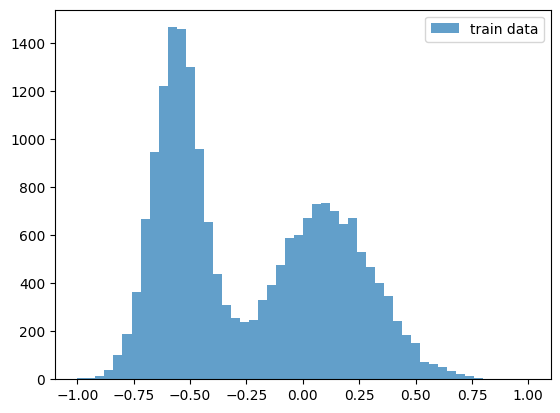

In [ ]:
visualize_q1_dataset()


We'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 



### Solution

In [ ]:
def train(generator, critic, c_loss_fn, g_loss_fn, train_loader, g_optimizer, c_optimizer, n_critic=1, 
          g_scheduler=None, c_scheduler=None, weight_clipping=None, preparer_fn=None):
    """
    generator: 
    critic: discriminator in 1ab, general model otherwise
    c_loss_fn: takes (generator, discriminator, real_batch)
    g_loss_fn: takes (generator, discriminator, real_batch)
    train_loader: instance of DataLoader class
    optimizer: 
    ncritic: how many critic gradient steps to do for every generator step
    """
    g_losses, c_losses = [], []
    generator.train()
    critic.train()
    for i, x in enumerate(train_loader):
        if preparer_fn is not None:
            x = preparer_fn(x)
        else:
            x = x.to(device).float()

        # discriminator/critic step
        # YOUR CODE

        if i % n_critic == 0:
            # generator step
            # YOUR CODE

            if g_scheduler is not None:
                g_scheduler.step()
            if c_scheduler is not None:
                c_scheduler.step()
    return dict(g_losses=g_losses, c_losses=c_losses)

def train_epochs(generator, critic, g_loss_fn, c_loss_fn, train_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    if 'optim_cls' in train_args:
        g_optimizer = train_args['optim_cls'](generator.parameters(), lr=lr)
        c_optimizer = train_args['optim_cls'](critic.parameters(), lr=lr)
    elif 'optim_g' in train_args and 'optim_c' in train_args:
        g_optimizer, c_optimizer = train_args['optim_g'], train_args['optim_c']
    else:
        g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
        c_optimizer = optim.Adam(critic.parameters(), lr=lr, betas=(0, 0.9))
        
    if train_args.get('lr_schedule', None) is not None:
        g_scheduler = optim.lr_scheduler.LambdaLR(g_optimizer, train_args['lr_schedule'])
        c_scheduler = optim.lr_scheduler.LambdaLR(c_optimizer, train_args['lr_schedule'])
    else:
        g_scheduler = None
        c_scheduler = None 

    train_losses = dict()
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        generator.train()
        critic.train()
        train_loss = train(generator, critic, c_loss_fn, g_loss_fn, train_loader, 
                           g_optimizer, c_optimizer, n_critic=train_args.get('n_critic', 0), 
                           g_scheduler=g_scheduler, c_scheduler=c_scheduler,
                           weight_clipping=train_args.get('weight_clipping', None),
                           preparer_fn=train_args.get('preparer_fn', None))
        
        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
            train_losses[k].extend(train_loss[k])

    if train_args.get('q1', False):  # q1, return the snapshots
        final_snapshot = get_training_snapshot(generator, critic)
        return [train_losses, *final_snapshot]
    else:
        return train_losses

def get_training_snapshot(generator, critic, n_samples=5000):
    generator.eval()
    critic.eval()
    xs = np.linspace(-1, 1, 1000)
    samples = generator.sample(n_samples).detach().cpu().numpy()
    critic_output = critic(torch.tensor(xs, device=device).float().unsqueeze(1)).detach().cpu().numpy()
    return samples, xs, critic_output

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, hidden_size, output_size):
        # YOUR CODE
        pass
    
    def forward(self, x):
        pass

class MLPGenerator(nn.Module):
    def __init__(self, latent_dim, n_hidden, hidden_size, data_dim, device='cuda'):
        super().__init__()
        # YOUR CODE

    def forward(self, z):
        pass


    def sample(self, n):
        pass

class MLPDiscriminator(nn.Module):
    def __init__(self, latent_dim, n_hidden, hidden_size, data_dim, device='cuda'):
        super().__init__()
        # YOUR CODE

    def forward(self, z):
        pass

In [ ]:
device = 'cuda:0'
def q1_a(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """
  
    # create data loaders
    train_loader = data.DataLoader(train_data, batch_size=64, shuffle=True)

    # model
    g = MLPGenerator(1, 3, 128, 1).to(device)
    c = MLPDiscriminator(1, 3, 128, 1).to(device)

    # loss functions
    def g_loss(generator, critic, x):
        # YOUR_CODE

    def c_loss(generator, critic, x):
        # YOUR CODE

    train_losses, samples, xs, ys = train_epochs(g, c, g_loss, c_loss, train_loader, dict(epochs=25, lr=1e-4, n_critic=2, q1=True))

    return train_losses['c_losses'], samples, xs, ys

### Results

In [ ]:
def plot_gan_training(losses, title, fname):
    plt.figure()
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.plot(xs, losses, label='loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Training Iteration')
    plt.ylabel('Loss')
    # savefig(fname)

def q1_gan_plot(data, samples, xs, ys, title, fname):
    plt.figure()
    plt.hist(samples, bins=50, density=True, alpha=0.7, label='fake')
    plt.hist(data, bins=50, density=True, alpha=0.7, label='real')

    plt.plot(xs, ys, label='discrim')
    plt.legend()
    plt.title(title)
    # savefig(fname)

def q1_save_results(part, fn):
    data = q1_data()
    losses, samples, xs, ys = fn(data)

    # loss plot
    plot_gan_training(losses, 'Q1{} Losses'.format(part), 'results/q1{}_losses.png'.format(part))

    # samples
    q1_gan_plot(data, samples, xs, ys, 'Q1{} Final'.format(part), 'results/q1{}_final.png'.format(part))

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

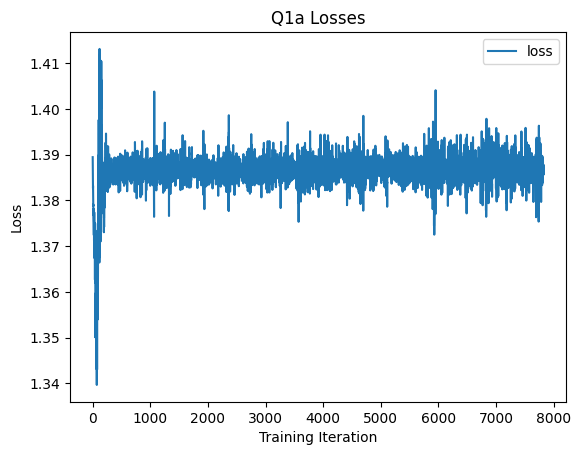

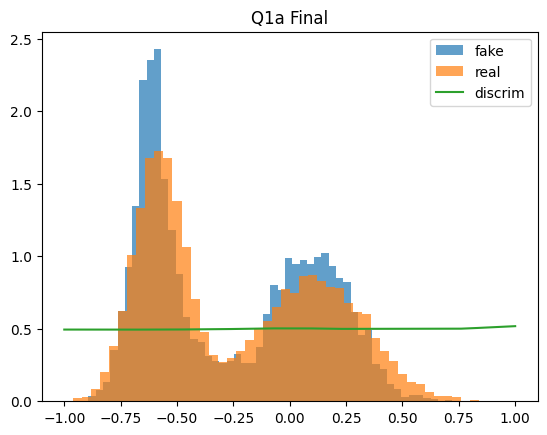

In [ ]:
q1_save_results('a', q1_a)

## Part 2 (MNIST)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate losses:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z))$$

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

In [ ]:
mnist_t = MNIST("./", train=False, download=True)

In [ ]:
normalize = lambda x: (x.astype(np.float32) - 127.5) / 127.5
restore = lambda x: (x * 127.5 + 127.5).astype(np.uint8)

def get_dataset(is_train):
    data = MNIST("./", train=is_train, download=True)
    data = [np.expand_dims(np.array(data[i][0]), 0) for i in range(len(data))]
    data = np.stack(data)
    return data

mnist_train, mnist_test = get_dataset(is_train=True), get_dataset(is_train=False)



In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape
        # YOUR_CODE

    def forward(self, z):
        pass

class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()
        # YOUR_CODE

    def forward(self, img):
        pass

In [ ]:
device = 'cuda:0'

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

def train_mnist(batch_size=64, latent_dim=128, lr=3e-4):
    train_loader = data.DataLoader(normalize(mnist_train), batch_size=batch_size, shuffle=True, num_workers=4)

    data_shape = (1, 28, 28)

    g = Generator(latent_dim=latent_dim, img_shape=data_shape).to(device)
    c = Discriminator(img_shape=data_shape).to(device)

    def g_loss(generator, critic, x):
        # YOUR_CODE

    def c_loss(generator, critic, real):
        # YOUR_CODE

    @torch.no_grad()
    def sample(n_samples):
        # YOUR_CODE

    train_args = {
        'epochs': 20,
        'n_critic': 1,
        'lr': lr,
        'optim_g': torch.optim.Adam(g.parameters(), lr=lr, betas=(0.5, 0.999)),
        'optim_c': torch.optim.Adam(c.parameters(), lr=lr, betas=(0.5, 0.999))
    }
    losses = train_epochs(g, c, g_loss, c_loss, train_loader, train_args)
    samples = sample(100)
    return losses, samples

losses, samples = train_mnist()


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
def show_samples(samples, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples) / 255)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

show_samples(samples)

## Part 3 (pixtopix Image-To-Image GAN)

In [ ]:
!wget -N http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz -O ./facades.tar.gz
!mkdir -p facades
!tar -zxf ./facades.tar.gz -C ./
!rm ./facades.tar.gz

for details.

--2023-04-19 07:29:17--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘./facades.tar.gz’

./facades.tar.gz    100%[===================>]  28.77M  2.47MB/s    in 14s     

2023-04-19 07:29:31 (2.04 MB/s) - ‘./facades.tar.gz’ saved [30168306/30168306]



In [ ]:
import os
import numpy as np
from PIL import Image
import functools

train_path, test_path = "./facades/train", "./facades/test"

def load_dataset(path):
    data = []
    for name in os.listdir(path):
        sample = Image.open(os.path.join(path, name)).convert('RGB')
        w, h = sample.size
        from_img, to_img = sample.crop((w//2, 0, w, h)), sample.crop((0, 0, w//2, h))
        data.append((from_img, to_img))
    return data

train_data, test_data = load_dataset(train_path), load_dataset(test_path)

def normalize(data):
    return (data.astype(np.float32) - 127.5) / 127.5

def restore(data):
    return (data * 127.5 + 127.5).astype(np.uint8)

def prepare_img(img, tgt_res):
    w, h = img.size
    if (w, h) != tgt_res:
        img = img.resize(tgt_res)
    img = np.array(img).transpose(2, 0, 1)
    return normalize(img)

def prepare_dataset(data, tgt_size=256):
    tgt_res = (tgt_size, tgt_size)
    prepared_data = []
    for from_img, to_img in data:
        prepared_data.append((prepare_img(from_img, tgt_res), prepare_img(to_img, tgt_res)))
    return prepared_data

Paper link: https://arxiv.org/pdf/1611.07004.pdf

Objectives:

$$
L_{cGAN}(G,D) = \mathbb{E}_{y}[logD(y)] + \mathbb{E}_{x,z}[log(1 - D(G(x,z)))]
$$
$$
L_{L_1}(G) = \mathbb{E}_{x,y,z}[\Vert y - G(x,z) \Vert_1]
$$

$$
G^* = arg min_G max_D L_{cGAN}(G,D) + \lambda L_{L_1}(G)
$$

In [ ]:
class UnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, norm_type=nn.BatchNorm2d):
        # YOUR_CODE

    def forward(self):
        pass

class ConvDiscriminator(nn.Module):
    def __init__(self, input_nc, norm_layer=nn.BatchNorm2d):
        # YOUR_CODE

    def forward(self):
        pass


In [ ]:
device='cuda:0'

def train_pixtopix(batch_size=64, input_res=256, lr=3e-4, penalty_lambda=100.0):
    prepared_train = prepare_dataset(train_data, tgt_size=input_res)
    prepared_test = prepare_dataset(test_data, tgt_size=input_res)

    train_loader = data.DataLoader(prepared_train, batch_size=batch_size, shuffle=True, num_workers=4)
    data_shape = (1, 28, 28)

    # define models here

    def tensor_preparer(batch):
        return batch[0].to(device), batch[1].to(device)

    def g_loss(generator, critic, x):
        # YOUR_CODE

    def c_loss(generator, critic, x):
        # YOUR_CODE

    @torch.no_grad()
    def sample(from_images):
        # YOUR_CODE

    train_args = {
        'epochs': 20,
        'n_critic': 1,
        'lr': lr,
        'optim_g': torch.optim.Adam(g.parameters(), lr=lr, betas=(0.5, 0.999)),
        'optim_c': torch.optim.Adam(c.parameters(), lr=lr, betas=(0.5, 0.999)),
        'preparer_fn': tensor_preparer
    }
    losses = train_epochs(g, c, g_loss, c_loss, train_loader, train_args)
    
    # make_samples
    # YOUR_CODE
    
    return losses, samples

losses, samples = train_pixtopix()